In [302]:
import mysql.connector
from mysql.connector import errorcode
import psycopg2 as pg

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, OldScalarFormatter
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc, quotes_historical_yahoo_ohlc
import matplotlib.ticker as plticker
%matplotlib inline

DATABASE = 'stage'

par_1_9 = 20
par_2_26 = 60
par_3_52 = 120
par_4_26 = 30


if DATABASE == 'prod':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-primary-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }
    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'stage':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-postgres-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '5432',
      'dbname': 'primary_postgres'
    }

    try:
      db_connection = pg.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
    


In [303]:
def check_signal(transaction_coin, counter_coin, R_PERIOD):

    query = "SELECT * FROM indicator_price WHERE transaction_currency='%s' AND counter_currency=%d "
    query = query % (transaction_coin, counter_coin)
    df_sql = pd.read_sql(query, con=db_connection)
    df_sql['timestamp'] = pd.to_datetime(df_sql['timestamp'], unit='s')
    df_sql.index = pd.DatetimeIndex(df_sql.timestamp)

    price_ts = df_sql.tail(10000).price * 10**-8

    price_high_ts = price_ts.resample(rule=R_PERIOD).max()
    price_low_ts = price_ts.resample(rule=R_PERIOD).min()
    closing_price_ts = price_ts.resample(rule=R_PERIOD).last()
    open_price_ts = price_ts.resample(rule=R_PERIOD).first()
    midpoint_price_ts = (price_high_ts + price_low_ts)/2

    tenkan_sen_conversion = midpoint_price_ts.rolling(window=par_1_9, center=False, min_periods=5).mean()
    kijun_sen_base = midpoint_price_ts.rolling(window=par_2_26, center=False, min_periods=15).mean()
    senkou_span_a_leading = ((tenkan_sen_conversion + kijun_sen_base) / 2).shift(par_2_26)
    period52 = midpoint_price_ts.rolling(window=par_3_52, center=False, min_periods=25).mean()
    senkou_span_b_leading = period52.shift(par_2_26)
    hikou_span_lagging = closing_price_ts.shift(-par_2_26)

    # combine everythin into one dataFrame
    df = pd.DataFrame({
        'idx_col': price_low_ts.index,
        'low': price_low_ts,
        'high': price_high_ts, 
        'closing': closing_price_ts,
        'open': open_price_ts,
        'conversion' : tenkan_sen_conversion,
        'base' : kijun_sen_base,
        'leading_a': senkou_span_a_leading,
        'leading_b': senkou_span_b_leading,
        'lagging': hikou_span_lagging
    })
    df = df[['low','high', 'open', 'closing', 'conversion', 'base', 'leading_a','leading_b','lagging','idx_col']]
    df_candle = df[['idx_col','open','high','low','closing']]


    # calculate new line indicators as time series
    tenkan_sen_conversion = midpoint_price_ts.rolling(window=par_1_9, center=False, min_periods=5).mean()
    kijun_sen_base = midpoint_price_ts.rolling(window=par_2_26, center=False, min_periods=15).mean()

    senkou_span_a_leading = ((tenkan_sen_conversion + kijun_sen_base) / 2).shift(par_2_26)
    period52 = midpoint_price_ts.rolling(window=par_3_52, center=False, min_periods=25).mean()

    senkou_span_b_leading = period52.shift(par_2_26)
    hikou_span_lagging = closing_price_ts.shift(-par_2_26)

    # combine everythin into one dataFrame
    df = pd.DataFrame({
        'idx_col': closing_price_ts.index,
        'low': price_low_ts,
        'high': price_high_ts,
        'closing': closing_price_ts,
        'conversion': tenkan_sen_conversion,
        'base': kijun_sen_base,
        'leading_a': senkou_span_a_leading,
        'leading_b': senkou_span_b_leading,
        'lagging': hikou_span_lagging
    })

    df['closing_below_cloud'] = np.where(((df.closing < df.leading_a) & (df.closing < df.leading_b)), 1, 0)

    df['closing_cloud_breakout_down'] = np.sign(
        df.closing - pd.concat([df.leading_a, df.leading_b], axis=1).min(axis=1)
    ).diff().fillna(0).lt(0)

    df['closing_cloud_breakout_down_extended'] = df['closing_cloud_breakout_down'] | df['closing_cloud_breakout_down'].shift(1)

    df['lagging_below_cloud'] = np.where(
        ((df.lagging.shift(par_4_26) < df.leading_a.shift(par_4_26)) &
         (df.lagging.shift(par_4_26) < df.leading_b.shift(par_4_26))),
        1, 0)
    df['lagging_below_cloud'] = df['lagging_below_cloud'].shift(par_4_26)

    df['lagging_below_lowest'] = np.where(df.lagging.shift(par_4_26) < df.low.shift(par_4_26), 1, 0)
    df['lagging_below_lowest'] = df['lagging_below_lowest'].shift(par_4_26)

    df['conversion_below_base'] = np.where(df.conversion < df.base, 1, 0)

    df['kumo_breakout_down_rules'] = np.where(
            (df.closing_cloud_breakout_down_extended &
             df.lagging_below_cloud &
             df.lagging_below_lowest &
             df.conversion_below_base
             ) == True, 1, 0)

    df['kumo_breakout_down_signals'] = df.kumo_breakout_down_rules.diff().gt(0)
    
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
    fig.suptitle("%s/%d Ichimoku Cloud" % (transaction_coin, counter_coin))
    ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))

    fmt = ScalarFormatter(useOffset=False)
    fmt.set_scientific(False)    
    ax1.yaxis.set_major_formatter(fmt)

    ax1.grid(True)
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax1.xaxis.set_major_locator(loc)

    #candlestick_ohlc(ax1, df_candle)

    #ax1.plot(df.high, color='black', linewidth=1)
    #ax1.plot(df.low, color='black', linewidth=1)
    ax1.plot(df.closing, color='black', linewidth=1)
    ax1.plot(df.conversion, linestyle=':', color='orange')
    ax1.plot(df.base, linestyle='--', color='orange')
    ax1.plot(df.leading_a, linestyle='--', color='magenta')
    ax1.plot(df.leading_b, linestyle='-', color='magenta')

    ax1.fill_between(senkou_span_a_leading.index, df.leading_a, df.leading_b, color='lightskyblue')

    ax1.plot(hikou_span_lagging, linestyle='-', color='lightblue')

    # buy signal
    for time_of_signal in df[df['kumo_breakout_down_signals']==True].index:
        ax1.axvline(time_of_signal, color='red')

    # sell signal
    #for time_of_signal in df[df.conversion_cross_base_down==True].index:
    #    ax1.axvline(time_of_signal, color='red')

    plt.show()


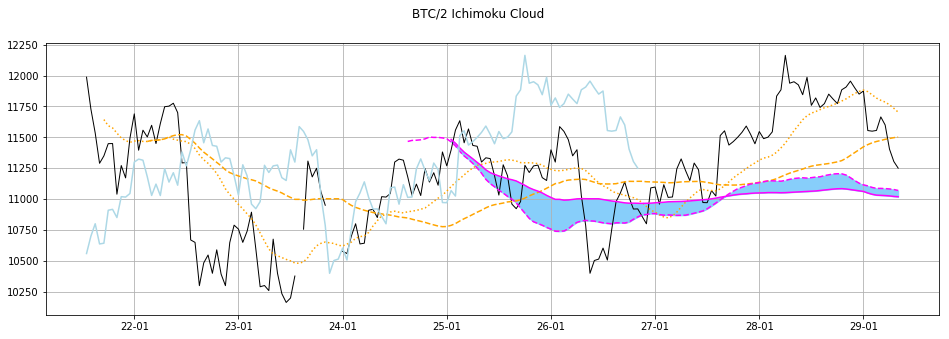

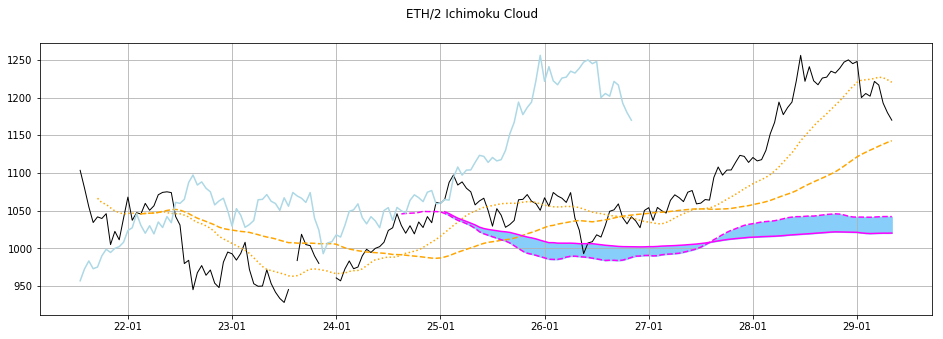

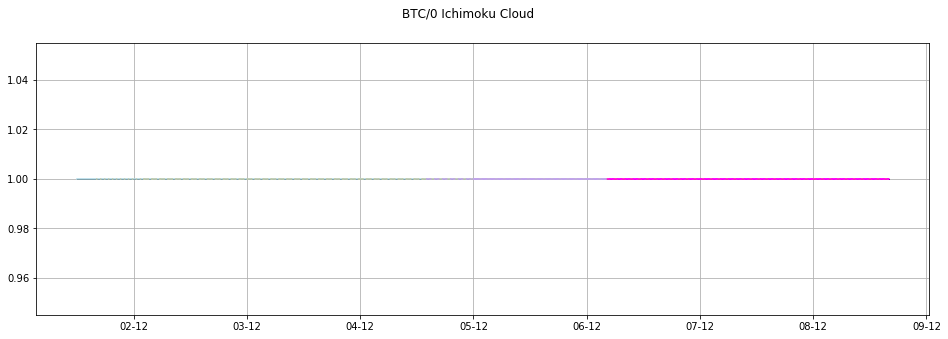

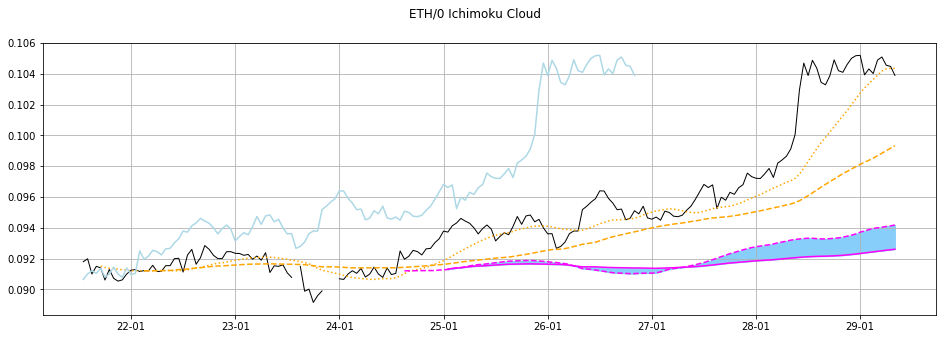

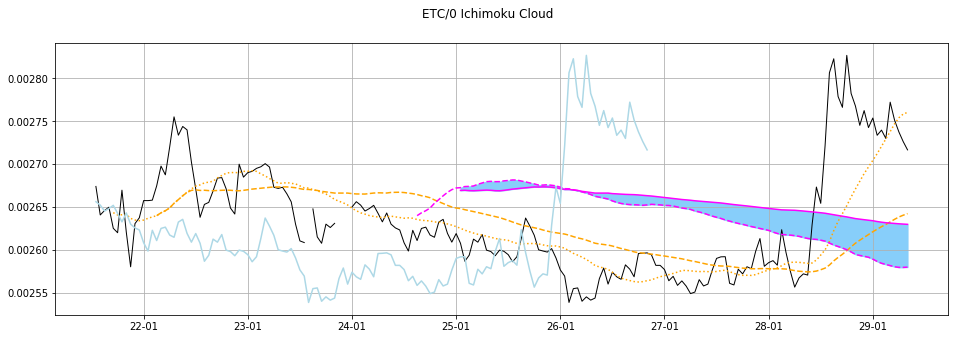

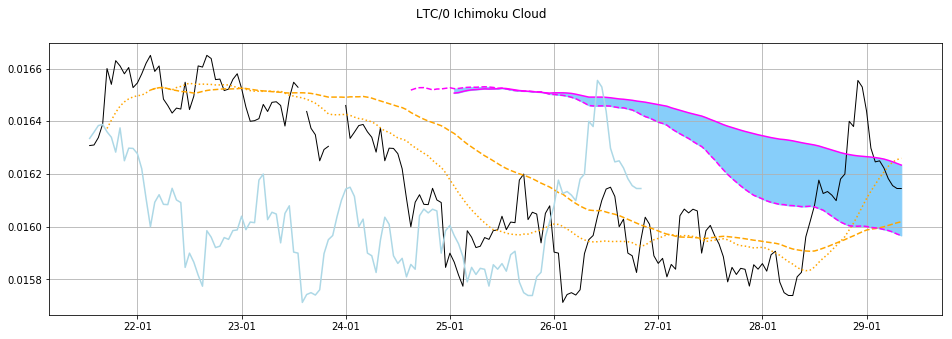

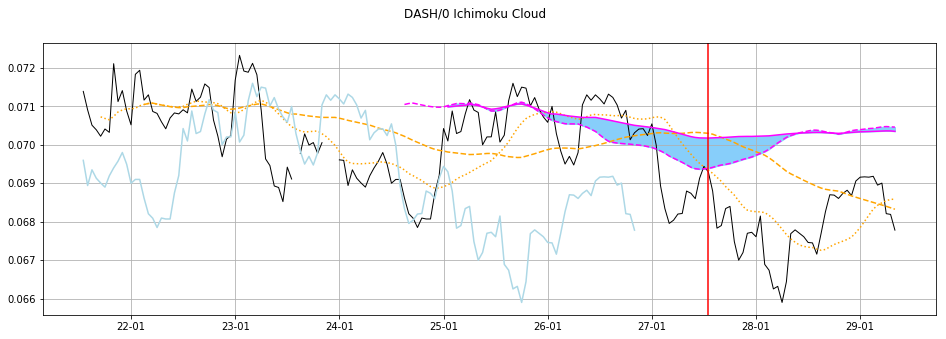

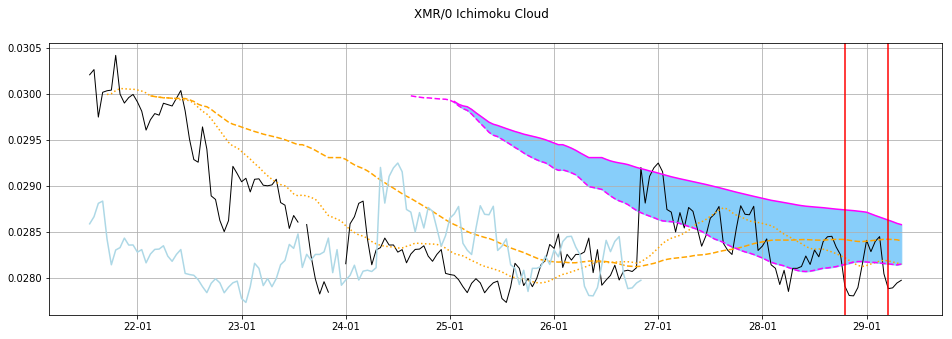

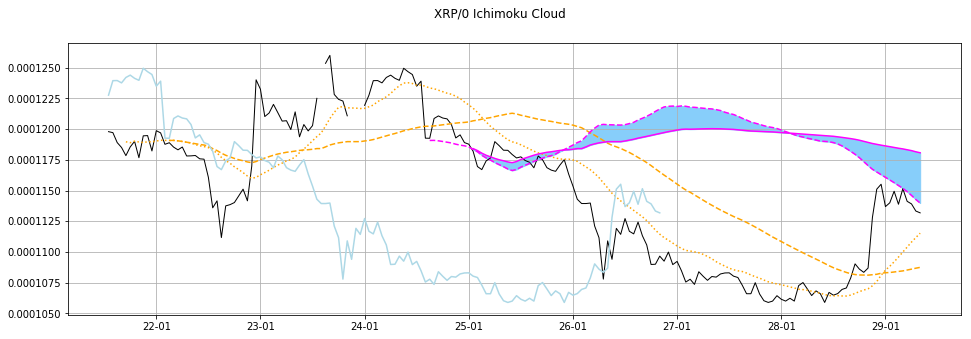

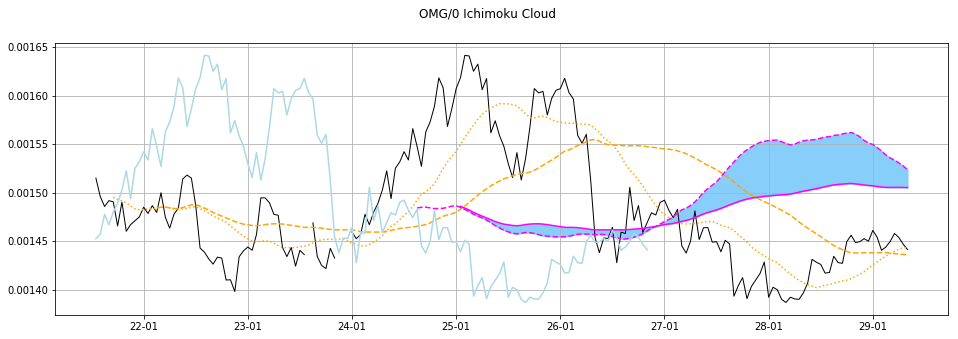

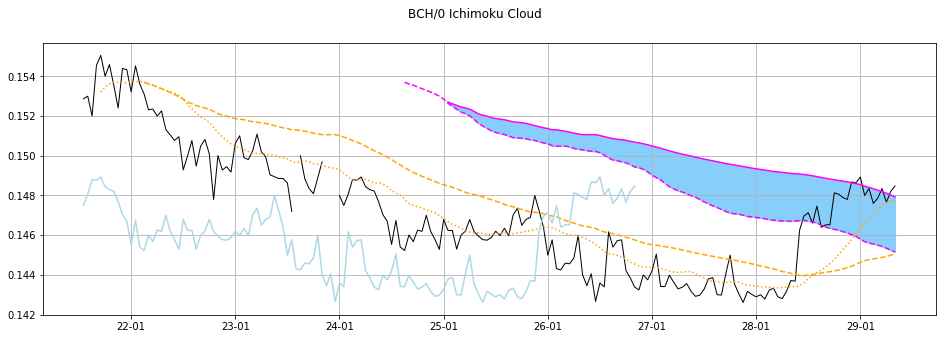

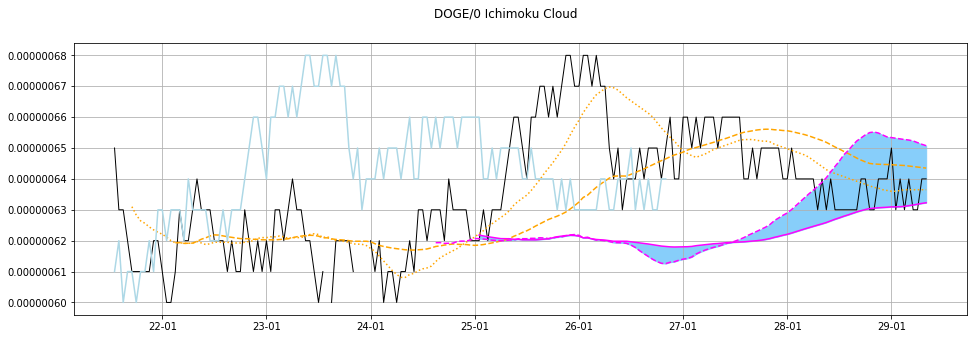

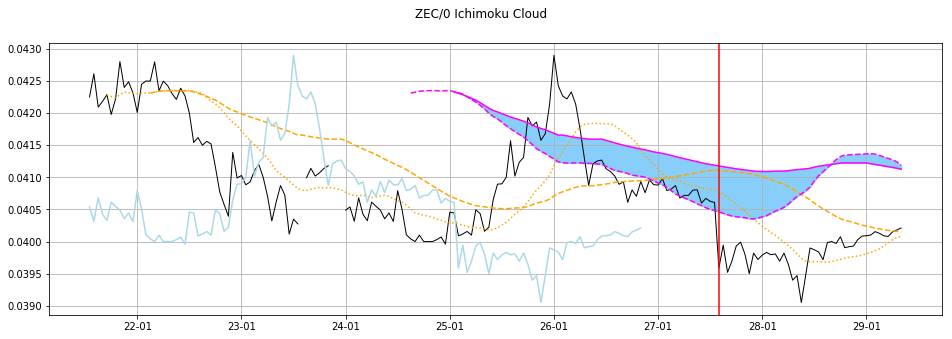

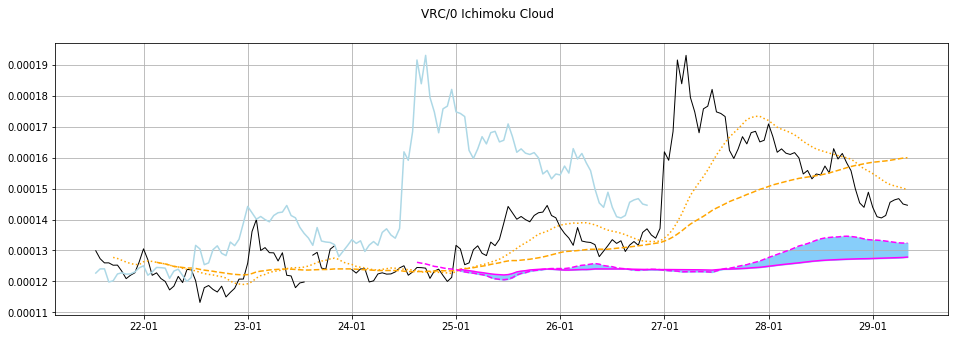

In [304]:
R_PERIOD='1H' #'30min' #'1H'
coins = ["BTC", "ETH", "ETC", "LTC", "DASH", "XMR", "XRP", "OMG", "BCH", "DOGE", "ZEC", "VRC"]
counter = 0 # 0 - BTC / 2 - USD

check_signal(transaction_coin="BTC", counter_coin=2, R_PERIOD=R_PERIOD)
check_signal(transaction_coin="ETH", counter_coin=2, R_PERIOD=R_PERIOD)
for coin in coins:
    check_signal(transaction_coin=coin, counter_coin=counter, R_PERIOD=R_PERIOD)